# ToDos
* Figure out what's the right way
* Do it in this way

# Setup

In [1]:
debug = True

make_ridge_models = True
n_gridder_repeats = 100
regression_type = 'repeatedCV'  # 'regular'  # 'ridge', 'repeatedCV'

make_boot_models = False
n_boot_models = 100

## Imports

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import regressors
from regressors import stats as rstats
from scipy import stats as sstats
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RepeatedKFold
import sklearn.linear_model as sklin
import sklearn.metrics as skmet
from scipy.stats import ttest_ind_from_stats, ttest_1samp
from Functions import get_category_dict, get_category_from_feature

In [3]:
from Functions import get_param_names, get_ages_cols, get_category_dict, get_category_from_feature, \
RepeatableGridSearchCV, make_gridder_pd

## Directories etc.

In [4]:
data_save_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta/all_data"
plot_save_path = "C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots"
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

## Get data

In [5]:
category_dict = get_category_dict()

In [6]:
all_data = pd.read_csv(os.path.join(data_save_path, 'all_data.csv'), index_col=0)
all_data_z = pd.read_csv(os.path.join(data_save_path, 'all_data_z.csv'), index_col=0)
all_data_long = pd.read_csv(os.path.join(data_save_path, 'all_data_long.csv'), index_col=0)
all_data_long_z = pd.read_csv(os.path.join(data_save_path, 'all_data_long_z.csv'), index_col=0)

In [7]:
category_dict = get_category_dict()
ages_cols = get_ages_cols()

param_cols = list(set([c for c in all_data.columns for p in get_param_names()
                       if (p in c) and ('ps_p_switch' not in c) and ('ps_p_reward' not in c)]))
print(param_cols)

behav_cols = []
for cat in ['RT', 'ACC', 'WS', 'LS', 'Delay']:
    behav_cols += category_dict[cat]
behav_cols = [c for c in behav_cols if ('RTsd' not in c) and ('ps_LWS' not in c) and ('bf_prew' not in c)]
print(behav_cols)

['bf_forget', 'rl_rho', 'bf_1_over_beta', 'rl_epsilon_1_over_beta', 'ps_alpha', 'rl_K', 'ps_nalpha', 'ps_1_over_beta', 'bf_alpha', 'rl_log_nalpha', 'ps_persev', 'rl_forget', 'rl_log_alpha']
['rl_RT', 'bf_RT', 'ps_RT', 'rl_ACC', 'bf_ACC', 'ps_ACC', 'rl_WS', 'bf_WS', 'ps_WS', 'rl_LS', 'bf_LS', 'ps_LS', 'bf_delay', 'rl_lrn_delay_sig']


# Predict parameters of one task from the others

## Repeated CV

In [8]:
# Define model for gridder
gridder_params = {
    'model': Ridge(),
    'n_repeats': n_gridder_repeats,
    'n_splitss': np.arange(2, 8),
    'scoring': 'r2',
    'param_grid': {'alpha': [0, 10, 30, 50, 1e2, 3e2, 5e2, 1e3, 3e3, 5e3, 1e4, 1e5, 1e6]},
}

if debug:
    gridder_params['n_repeats'] = 2
    gridder_params['n_splitss'] = [3, 5, ]
    gridder_params['param_grid'] = {'alpha': [0, 50]}

In [9]:
def run_regression_get_r2_coef(X_dat, y_dat, y_col, predictor_task,
                               regression_type='regular', gridder_params=gridder_params):
    
    # Select regression model
    if regression_type == 'regular':
        mod = sm.OLS(y_dat[y_col], X_dat)
        result = mod.fit()
        
        coef_row = pd.DataFrame({
            'coef': result.params,
            'coef_sd': result.bse,
            'coef_lower': result.conf_int()[0],
            'coef_upper': result.conf_int()[1],
            'p': result.pvalues,
        }).reset_index().rename(columns={'index': 'predictor'})
        coef_row['outcome'] = y_col
        coef_row['pred_task'] = predictor_task
        
        r2_row = pd.DataFrame({
            'r2': [result.rsquared], 'aic': [result.aic],
            'outcome': [y_col], 'pred_task': [predictor_task],
            'r2sd': [0], 'n_splits': [1], 'X_cols': '.'.join(X_dat.columns)
        })
        
    elif regression_type == 'repeatedCV':
        r2_row = pd.DataFrame()
        coefs = pd.DataFrame()

        for i, n_splits in enumerate(gridder_params['n_splitss']):
            
            ### STEP 1: GET R^2
            # Fit regression model
            mod = RepeatableGridSearchCV(
                gridder_params['model'], gridder_params['param_grid'], n_repeats=gridder_params['n_repeats'],
                n_splits=n_splits, scoring=gridder_params['scoring']
            )
            mod.fit(X_dat, y_dat[y_col])

            # Make pretty
            gridder_results = make_gridder_pd(mod)
            gridder_results['outcome'] = y_col
            gridder_results['X_cols'] = '.'.join(X_dat.columns)
            gridder_results['pred_task'] = predictor_task
            gridder_results['n_splits'] = n_splits

            # Append
            r2_row = r2_row.append(gridder_results)
            
            ### STEP 2: GET COEFFICIENTS
            # Fit model
            best_model = gridder_results.loc[gridder_results['mean_test_score'] == np.max(gridder_results['mean_test_score'])]
#             model = TransformedTargetRegressor(  # https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
#                         regressor=RidgeCV(
#                             alphas=[best_model['param_alpha'].values[0]],
#                             cv=RepeatedKFold(n_splits=n_splits, n_repeats=gridder_params['n_repeats'])),
#             )
            model = Ridge(alpha=[best_model['param_alpha'].values[0]])
            result = model.fit(X_dat, y_dat[y_col])

#             # Get coefficients
#             coef_row = pd.DataFrame(
#                 model.regressor_.coef_, columns=['coef'], index=X_dat.columns
#             ).reset_index().rename(columns={'index': 'predictor'})
            coef_row = pd.DataFrame(
                result.coef_, columns=['coef'], index=X_dat.columns
                ).reset_index().rename(columns={'index': 'predictor'})
            coef_row['p'] = rstats.coef_pval(result, X_dat, y_dat[y_col])[1:]
            coef_row['coef_se'] = rstats.coef_se(result, X_dat, y_dat[y_col])[1:]
            coef_row['outcome'] = y_col
            coef_row['X_cols'] = '.'.join(X_dat.columns)
            coef_row['pred_task'] = predictor_task
            coef_row['n_splits'] = n_splits
            
    return r2_row, coef_row
    
# # Example use
# X_dat = all_data_z[[c for c in param_cols if ('rl_' in c) or ('ps_' in c)]]
# y_col = 'bf_1_over_beta'
# y_dat = all_data_z
# run_regression_get_r2_coef(X_dat, y_dat, y_col, 'blab', regression_type=regression_type)[0]

## Ridge regression / regular regression

### Parameter models

In [10]:
def run_all_param_regression_models(cols, all_data_z):

    # Set up empty DataFrames
    coef_dat = pd.DataFrame()
    r2_dat = pd.DataFrame()

    # Predict each parameter from just behavior
    dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols]].dropna()

    # Predict 1 task from 1 task
    dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols]].dropna()
    for predictor_task in ['bf_', 'rl_', 'ps_']:
        print('params_' + predictor_task)

        # Get predictor and outcome data
        X_dat = dat[[c for c in cols if predictor_task in c]]
        y_dat = dat[[c for c in cols if predictor_task not in c]]

        for y_col in y_dat.columns:
            
            # Run regression
            r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'params_' + predictor_task, regression_type=regression_type)

            # Concat data
            coef_dat = pd.concat([coef_dat, coef_row])
            r2_dat = pd.concat([r2_dat, r2_row])

    # Predict 1 task from the other 2 tasks
    print('params_both')
    for outcome_task in ['bf_', 'rl_', 'ps_']:

        # Get predictor and outcome data
        X_dat = dat[[c for c in cols if outcome_task not in c]]
        y_dat = dat[[c for c in cols if outcome_task in c]]

        for y_col in y_dat.columns:

            # Run regression
            r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'params_both', regression_type=regression_type)

            # Concat data
            coef_dat = pd.concat([coef_dat, coef_row])
            r2_dat = pd.concat([r2_dat, r2_row])
        
    return r2_dat, coef_dat

# # Example use
# run_all_param_regression_models(param_cols, all_data_z)

### Behavior models

In [12]:
def run_all_behav_regression_models(all_data_z):

    # Set up empty DataFrames
    coef_dat = pd.DataFrame()
    r2_dat = pd.DataFrame()

    # Predict each parameter from just behavior
    dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols]].dropna()

    for outcome_task in ['bf_', 'rl_', 'ps_']:
        print('behav_' + outcome_task)

        # Get predictor and outcome data
        X_dat = dat[behav_cols]
        y_dat = dat[[c for c in param_cols if outcome_task in c]]

        for y_col in y_dat.columns:

            # Run regression
            r2_row, coef_row = run_regression_get_r2_coef(
                X_dat, y_dat, y_col, 'behav_' + outcome_task, regression_type=regression_type
            )

            # Concat data
            coef_dat = pd.concat([coef_dat, coef_row])
            r2_dat = pd.concat([r2_dat, r2_row])
        
    return r2_dat, coef_dat

# # Example use
# r2_dat, coef_dat = run_all_behav_regression_models(all_data_z)
# r2_dat

behav_bf_
behav_rl_
behav_ps_


,mean_test_score,std_test_score,param_alpha,outcome,X_cols,pred_task,n_splits
0,0.640455,0.049190,0,bf_1_over_beta,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_bf_,2
1,0.659826,0.038925,10,bf_1_over_beta,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_bf_,2
2,0.662312,0.036895,30,bf_1_over_beta,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_bf_,2
3,0.655944,0.036238,50,bf_1_over_beta,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_bf_,2
4,0.629847,0.035482,100,bf_1_over_beta,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_bf_,2
...,...,...,...,...,...,...,...
8,0.014512,0.067575,3000,ps_alpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_ps_,7
9,-0.003125,0.066819,5000,ps_alpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_ps_,7
10,-0.019072,0.067047,10000,ps_alpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_ps_,7
11,-0.036122,0.068165,100000,ps_alpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_ps_,7


In [14]:
def beautify_coef_r2_df(dat):
    
    # Add and rename columns
    dat['out_task'] = dat['outcome'].apply(lambda x : x[:2])
    dat = dat.rename(columns={'mean_test_score': 'r2', 'std_test_score': 'r2sd'})
    dat['r2se'] = dat.apply(lambda x : x['r2sd'] / np.sqrt(x['n_splits']), axis=1)
    
    # Sort outcome column to plot the points in the right order
    dat['outcome'] = pd.Categorical(dat['outcome'], categories=[
        'bf_1_over_beta', 'bf_alpha', 'bf_forget',
        'ps_1_over_beta','ps_alpha', 'ps_nalpha', 'ps_persev',
        'rl_epsilon_1_over_beta', 'rl_log_alpha', 'rl_log_nalpha', 'rl_forget', 'rl_K', 'rl_rho',
    ])
    dat = dat.reset_index(drop=True)
    
    return dat

# # Example use
# beautify_coef_r2_df(dat)

In [15]:
save_dir = os.path.join(plot_save_path, 'r2_dat_behav_behav.csv')

if make_boot_models:
    r2_dat_behav, coef_dat_behav = run_all_behav_regression_models(all_data_z)
    r2_dat_behav = beautify_coef_r2_df(r2_dat_behav)

    print('Saving to {}'.format(save_dir))
    r2_dat_behav.to_csv(save_dir)
    
else:
    print('Reading from {}'.format(save_dir))
    r2_dat_behav = pd.read_csv(save_dir)

Saving to C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\r2_dat_behav.csv


In [19]:
best_scores = r2_dat.groupby(['outcome', 'X_cols']).aggregate('max').reset_index()[['outcome', 'X_cols', 'r2', 'r2se']]
best_models_behav = r2_dat.loc[r2_dat['r2'].isin(best_scores['r2'].values)].reset_index(drop=True)
best_models_behav

,r2,r2sd,param_alpha,outcome,X_cols,pred_task,n_splits,out_task,r2se
0,0.668144,0.064767,30,bf_1_over_beta,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_bf_,4,bf,0.032383
1,0.747886,0.049433,10,bf_alpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_bf_,5,bf,0.022107
2,0.454579,0.072200,10,bf_forget,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_bf_,4,bf,0.036100
3,0.269588,0.066633,100,rl_log_alpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,4,rl,0.033317
4,-0.010412,0.094649,30,rl_rho,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,4,rl,0.047324
5,0.080944,0.129247,100,rl_epsilon_1_over_beta,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,3,rl,0.074621
6,0.002116,0.033460,500,rl_K,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,3,rl,0.019318
7,0.045080,0.117677,100,rl_forget,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,7,rl,0.044478
8,0.504292,0.060386,30,rl_log_nalpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,3,rl,0.034864
9,0.592443,0.063455,10,ps_nalpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_ps_,4,ps,0.031728


In [20]:
best_models_behav.loc[
    (best_models_behav['outcome'] == 'rl_epsilon_1_over_beta')
]

,r2,r2sd,param_alpha,outcome,X_cols,pred_task,n_splits,out_task,r2se
5,0.080944,0.129247,100,rl_epsilon_1_over_beta,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,3,rl,0.074621


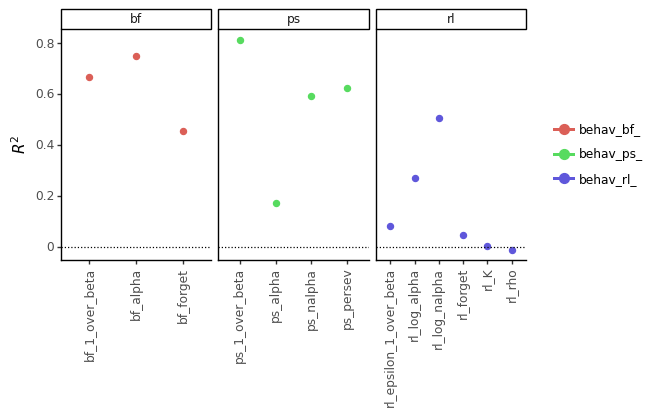

<ggplot: (138418174278)>

In [21]:
gg.options.figure_size = (6, 3)
g = (gg.ggplot(best_models_behav, gg.aes('outcome', 'r2', color='pred_task'))
     + gg.stat_summary(position=gg.position_dodge(width=0.4))
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
     + gg.geom_hline(yintercept=0, linetype='dotted')
     + gg.labs(x='', color='', y='$R^2$')
     + gg.facet_grid('~ out_task', scales='free')
    )
g

In [23]:
coef_dat_behav['out_cat'] = get_category_from_feature(coef_dat_behav['outcome'], category_dict)
coef_dat_behav

,predictor,coef,p,coef_se,outcome,X_cols,pred_task,n_splits,out_cat
0,rl_RT,-0.038242,0.401097,0.045466,bf_1_over_beta,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_bf_,7,Beta
1,bf_RT,0.092078,0.029124,0.041955,bf_1_over_beta,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_bf_,7,Beta
2,ps_RT,-0.021580,0.616611,0.043048,bf_1_over_beta,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_bf_,7,Beta
3,rl_ACC,0.052611,0.475704,0.073651,bf_1_over_beta,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_bf_,7,Beta
4,bf_ACC,-0.187623,0.007610,0.069720,bf_1_over_beta,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_bf_,7,Beta
...,...,...,...,...,...,...,...,...,...
9,rl_LS,0.006218,0.934151,0.075181,ps_alpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_ps_,7,Alpha
10,bf_LS,-0.000760,0.991890,0.074731,ps_alpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_ps_,7,Alpha
11,ps_LS,0.014713,0.829724,0.068340,ps_alpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_ps_,7,Alpha
12,bf_delay,-0.108218,0.107374,0.066966,ps_alpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_ps_,7,Alpha


In [24]:
coef_dat_behav.loc[
    (coef_dat_behav['outcome'].isin(['ps_nalpha', 'rl_log_nalpha']))
]

,predictor,coef,p,coef_se,outcome,X_cols,pred_task,n_splits,out_cat
0,rl_RT,-0.062220,2.570576e-01,0.054771,rl_log_nalpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,7,Nalpha
1,bf_RT,0.008075,8.731968e-01,0.050542,rl_log_nalpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,7,Nalpha
2,ps_RT,-0.005951,9.087343e-01,0.051858,rl_log_nalpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,7,Nalpha
3,rl_ACC,0.149095,9.414480e-02,0.088725,rl_log_nalpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,7,Nalpha
4,bf_ACC,-0.056571,5.012210e-01,0.083988,rl_log_nalpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,7,Nalpha
5,ps_ACC,-0.009761,8.713494e-01,0.060213,rl_log_nalpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,7,Nalpha
6,rl_WS,0.158445,3.875686e-02,0.076253,rl_log_nalpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,7,Nalpha
7,bf_WS,0.065834,4.895780e-01,0.095133,rl_log_nalpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,7,Nalpha
8,ps_WS,0.008759,8.821795e-01,0.059040,rl_log_nalpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,7,Nalpha
9,rl_LS,-0.411926,5.377698e-12,0.056816,rl_log_nalpha,rl_RT.bf_RT.ps_RT.rl_ACC.bf_ACC.ps_ACC.rl_WS.b...,behav_rl_,7,Nalpha


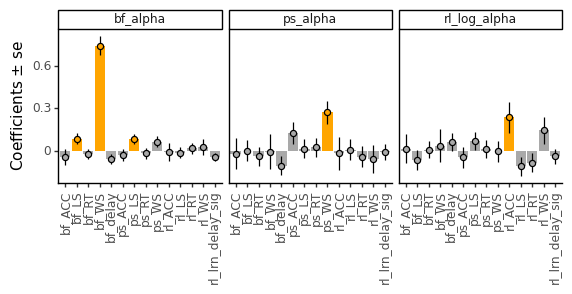

<ggplot: (138419693306)>


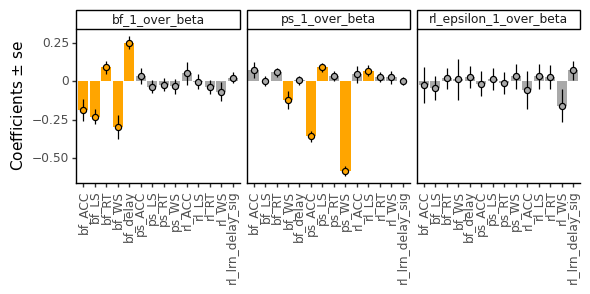

<ggplot: (138418203935)>


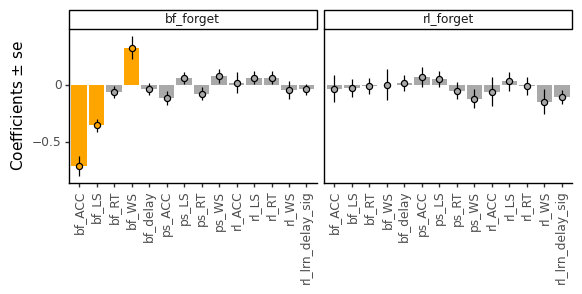

<ggplot: (138418207961)>


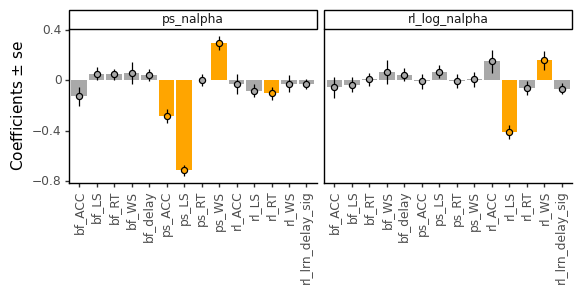

<ggplot: (138419989767)>


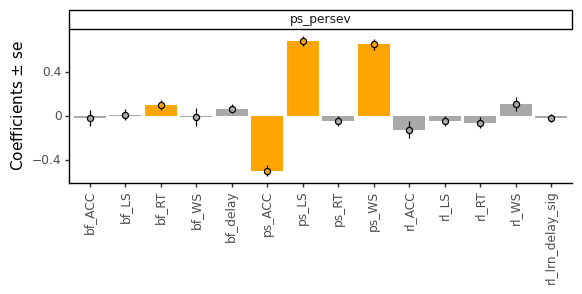

<ggplot: (138418204829)>


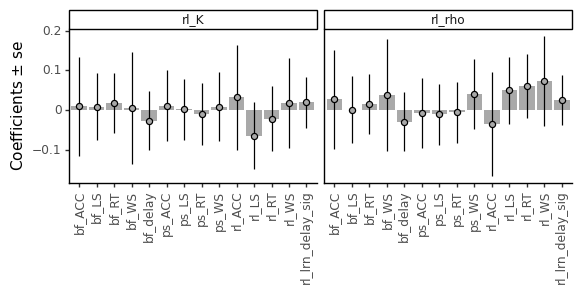

<ggplot: (138419520010)>


In [25]:
for out_cat in np.unique(coef_dat_behav['out_cat']):
    
    sub = coef_dat.loc[coef_dat_behav['out_cat'] == out_cat]

    gg.options.figure_size = (6.5, 2)
    g = (gg.ggplot(sub, gg.aes('predictor', 'coef', fill='p<0.05'))
         + gg.geom_bar(stat='identity')
         + gg.geom_pointrange(gg.aes(ymin='coef-coef_se', ymax='coef+coef_se'))
         + gg.labs(x='', y='Coefficients $\pm$ se')
         + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
         + gg.scale_fill_manual(['darkgrey', 'orange'])
         + gg.theme(legend_position='none')
         + gg.theme(subplots_adjust={'hspace': 1})
         + gg.facet_wrap('~ outcome', scales='free_x', nrow=1)
        )
    print(g)

In [ ]:
if make_ridge_models:
    r2_dat_params, coef_dat_params = run_all_param_regression_models(param_cols, all_data_z)
    # r2_dat_behav, coef_dat_behav = run_all_param_regression_models(behav_cols, all_data_z)
else:
    r2_dat_params = pd.read_csv(os.path.join(plot_save_path, 'r2_dat_params.csv'), index_col=0)
    coef_dat_params = pd.read_csv(os.path.join(plot_save_path, 'coef_dat_params.csv'), index_col=0)

In [ ]:
# Beautify DataFrames
if make_ridge_models:
    r2_dat_params = beautify_coef_r2_df(r2_dat_params)
#     r2_dat_params = r2_dat_params.rename(columns={'mean_test_score': 'r2', 'std_test_score': 'r2sd'})
#     r2_dat_params['r2se'] = r2_dat_params.apply(lambda x : x['r2sd'] / np.sqrt(x['n_splits']), axis=1)

    save_dir = os.path.join(plot_save_path, 'r2_dat_params.csv')
    print('Saving to {}'.format(save_dir))
    r2_dat_params.to_csv(save_dir)
r2_dat_params

In [ ]:
if make_ridge_models:
    coef_dat_params = beautify_coef_r2_df(coef_dat_params)
    coef_dat_params['out_category'] = get_category_from_feature(coef_dat_params['outcome'], category_dict)
    coef_dat_params['pred_category'] = get_category_from_feature(coef_dat_params['predictor'], category_dict)

    save_dir = os.path.join(plot_save_path, 'coef_dat_params.csv')
    coef_dat_params.to_csv(save_dir)
    print('Saving to {}'.format(save_dir))
coef_dat_params

In [ ]:
best_scores = r2_dat_params.groupby(['outcome', 'X_cols']).aggregate('max').reset_index()[['outcome', 'X_cols', 'r2', 'r2se']]
best_models = r2_dat_params.loc[r2_dat_params['r2'].isin(best_scores['r2'].values)].reset_index(drop=True)
best_models

## Bootstrap results

### Re-run each winning model 1000 times, for bootstrapping

In [ ]:
best_models

In [ ]:
# for _, best_model in best_models.iterrows():
#     model = TransformedTargetRegressor(  # https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
#                 regressor=RidgeCV(
#                     alphas=[best_model['param_alpha']],
#                     cv=RepeatedKFold(n_splits=n_splits, n_repeats=gridder_params['n_repeats'])),
#     )
#     model.fit(X_dat, y_dat[y_col])

In [ ]:
# n_splits = 20
# mod = TransformedTargetRegressor(  # https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
#             regressor=RidgeCV(
#                 alphas=[best_model['param_alpha']],
#                 cv=RepeatedKFold(n_splits=n_splits, n_repeats=2)),
# )
# mod.fit(X_dat, y_dat[y_col])
# # make_gridder_pd(mod)
# mod.regressor_.coef_
# mod.regressor_.score(X_dat, y_dat[y_col])

In [ ]:
def run_boot_models_r2(best_models, gridder_params, n_boot_models):
    
    boot_models_r2 = pd.DataFrame()

    for row_i, best_model in best_models.iterrows():
        
        print('{} / {} rows'.format(row_i+1, best_models.shape[0]))

        for i in range(n_boot_models):

            # Get gridder_params for this model
            gridder_params_boot = gridder_params.copy()
            gridder_params_boot['n_splitss'] = [best_model['n_splits']]
            gridder_params_boot['n_repeats'] = 2
            gridder_params_boot['param_grid'] = {'alpha': [best_model['param_alpha']]}
            gridder_params_boot

            # Run this model
            X_dat = all_data_z[best_model['X_cols'].split('.')]
            y_col = best_model['outcome']
            y_dat = all_data_z
            r2_row, _ = run_regression_get_r2_coef(
                X_dat, y_dat, y_col, best_model['pred_task'],
                regression_type=regression_type, gridder_params=gridder_params_boot
            )
            r2_row['iteration'] = i

            # Save in big dataframe
            boot_models_r2 = boot_models_r2.append(r2_row)
            
    return boot_models_r2

# # Example use
# run_boot_models_r2(best_models[38:], gridder_params, n_boot_models=2)

In [ ]:
def run_boot_models_coefs(best_models, gridder_params, n_boot_models):
    
    boot_models_coefs = pd.DataFrame()

    for row_i, best_model in best_models.iterrows():
        
        print('{} / {} rows'.format(row_i+1, best_models.shape[0]))

        for i in range(n_boot_models):

            # Get gridder_params for this model
            gridder_params_boot = gridder_params.copy()
            gridder_params_boot['n_splitss'] = [best_model['n_splits']]
            gridder_params_boot['n_repeats'] = 1
            gridder_params_boot['param_grid'] = {'alpha': [best_model['param_alpha']]}
            gridder_params_boot

            # Run this model
            X_dat = all_data_z[best_model['X_cols'].split('.')]
            y_col = best_model['outcome']
            y_dat = all_data_z
            _, coef_row = run_regression_get_r2_coef(
                X_dat, y_dat, y_col, best_model['pred_task'],
                regression_type=regression_type, gridder_params=gridder_params_boot
            )
            coef_row['iteration'] = i

            # Save in big dataframe
            boot_models_coefs = boot_models_coefs.append(coef_row)
            
    return boot_models_coefs

# # Example use
# run_boot_models_coefs(best_models[38:], gridder_params, n_boot_models=2)

In [ ]:
if make_boot_models:
    boot_models_r2 = run_boot_models_r2(best_models, gridder_params, n_boot_models)
    boot_models_coefs = run_boot_models_coefs(best_models, gridder_params, n_boot_models=1)
else:
    boot_models_r2 = pd.read_csv(os.path.join(plot_save_path, 'boot_models_r2 - Copy.csv'), index_col=0)
    boot_models_coefs = pd.read_csv(os.path.join(plot_save_path, 'boot_models_coefs - Copy.csv'), index_col=0)    

In [ ]:
# Beautify DataFrames
if make_boot_models:
    boot_models_r2 = beautify_coef_r2_df(boot_models_r2)
    boot_models_r2 = boot_models_r2.rename(columns={'mean_test_score': 'r2', 'std_test_score': 'r2sd'})
    boot_models_r2['r2se'] = boot_models_r2.apply(lambda x : x['r2sd'] / np.sqrt(x['n_splits']), axis=1)
boot_models_r2

In [ ]:
if make_boot_models:
    boot_models_coefs = beautify_coef_r2_df(boot_models_coefs)
    boot_models_coefs['out_category'] = get_category_from_feature(boot_models_coefs['outcome'], category_dict)
    boot_models_coefs['pred_category'] = get_category_from_feature(boot_models_coefs['predictor'], category_dict)
boot_models_coefs

In [ ]:
if make_boot_models:
    save_dir = os.path.join(plot_save_path, 'boot_models_r2_nit_{}.csv'.format(n_boot_models))
    boot_models_r2.to_csv(save_dir)
    print('Saving to {}'.format(save_dir))
    save_dir = os.path.join(plot_save_path, 'boot_models_coefs_nit_{}.csv'.format(n_boot_models))
    boot_models_coefs.to_csv(save_dir)
    print('Saving to {}'.format(save_dir))    

### Calculate stats of interest on these models

In [ ]:
boot_models_r2['r2<0'] = (boot_models_r2['r2'] < 0).astype(int)
boot_models_coefs['coef<0'] = (boot_models_coefs['coef'] < 0).astype(int)

In [ ]:
gg.options.figure_size = (6, 3)
g = (gg.ggplot(boot_models_r2, gg.aes('outcome', 'r2', color='pred_task'))
     + gg.stat_summary(position=gg.position_dodge(width=0.4))
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
     + gg.geom_hline(yintercept=0, linetype='dotted')
     + gg.labs(x='', color='', y='$R^2$')
     + gg.facet_grid('~ out_task', scales='free')
    )
g

In [ ]:
id_cols = ['X_cols', 'pred_task', 'outcome']
# summarize, calculate means, sd, and p-values
boot_models_r2_sum = boot_models_r2[id_cols + ['r2', 'r2<0']].groupby(id_cols).aggregate(['mean', 'std']).reset_index()
# flatten hierarchical columns
boot_models_r2_sum.columns = [
    high + low for high, low in
    zip(boot_models_r2_sum.columns.get_level_values(0), boot_models_r2_sum.columns.get_level_values(1))
]
# add out_task column
boot_models_r2_sum['out_task'] = boot_models_r2_sum['outcome'].apply(lambda x : x[:2])
boot_models_r2_sum

In [ ]:
boot_models_coefs.loc[
    (boot_models_coefs['outcome'] == 'ps_nalpha') & (boot_models_coefs['pred_task'] == 'params_bf_')
]

## Plots

## Old t-tests

In [ ]:
t_dat_params = pd.DataFrame()

# param_pred_tasks = ['both_params_and_age', 'ps_params_and_age', 'rl_params_and_age', 'bf_params_and_age']
param_pred_tasks = ['params_both', 'params_ps_', 'params_rl_', 'params_bf_']

for out_task in ['ps', 'bf', 'rl']:
    
    pre_dat = best_models.loc[
        (best_models['out_task'] == out_task) &
        (best_models['pred_task'].isin(param_pred_tasks))
    ]
    
    for outcome in np.unique(pre_dat['outcome']):
        dat = pre_dat.loc[pre_dat['outcome'] == outcome]

        for pred_task in param_pred_tasks:
            try:
                # Compare one task's R2 against 0
#                 ttest0 = ttest_ind_from_stats(
#                     mean1=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2'].values[0],
#                     std1=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2sd'].values[0],
#                     nobs1=dat.loc[dat['pred_task'] == pred_tasks[0], 'n_splits'].values[0],
#                     mean2=0,
#                     std2=0,
#                     nobs2=dat.loc[dat['pred_task'] == pred_tasks[1], 'n_splits'].values[0],
#                     equal_var=False
#                 )
#                 t_row = pd.DataFrame(
#                     {'outcome': [outcome], 'pred_task0': [pred_tasks[0]], 'pred_task1': [np.nan], 't': [ttest0[0]], 'p': [ttest0[1]]}
#                 )
#                 t_dat_params = t_dat_params.append(t_row)

                x_bar = dat.loc[dat['pred_task'] == pred_task, 'r2'].values[0]
                mu = 0
                sd = dat.loc[dat['pred_task'] == pred_task, 'r2sd'].values[0]
                n = dat.loc[dat['pred_task'] == pred_task, 'n_splits'].values[0]  # df based on n_splits
#                 n = gridder_params['n_repeats']  # df based on n_repeats
                
                t = (x_bar - mu) * np.sqrt(n) / sd
                p = sstats.t.pdf(x=t, df=n - 1)

                t_row = pd.DataFrame(
                    {'outcome': [outcome], 'pred_task0': [pred_task], 'pred_task1': [np.nan], 't': [t], 'p': [p]}
                )
                t_dat_params = t_dat_params.append(t_row)
                
            except IndexError:  # When one task does not exist in the dataframe because it is the predicted one
                pass
        
        for pred_tasks in itertools.combinations(param_pred_tasks, 2):
            
            # Compare two tasks' R2's against each other
            try:
                ttest = ttest_ind_from_stats(
                    mean1=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2'].values[0],
                    std1=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2sd'].values[0],
                    nobs1=dat.loc[dat['pred_task'] == pred_tasks[0], 'n_splits'].values[0],
#                     nobs1=gridder_params['n_repeats'],
                    mean2=dat.loc[dat['pred_task'] == pred_tasks[1], 'r2'].values[0],
                    std2=dat.loc[dat['pred_task'] == pred_tasks[1], 'r2sd'].values[0],
                    nobs2=dat.loc[dat['pred_task'] == pred_tasks[1], 'n_splits'].values[0],
#                     nobs2=gridder_params['n_repeats'],
                    equal_var=False
                )
                t_row = pd.DataFrame(
                    {'outcome': [outcome], 'pred_task0': [pred_tasks[0]], 'pred_task1': [pred_tasks[1]], 't': [ttest[0]], 'p': [ttest[1]]}
                )
                t_dat_params = t_dat_params.append(t_row)

            except IndexError:  # When one task does not exist in the dataframe because it is the predicted one
                pass

t_dat_params = t_dat_params.reset_index(drop=True)
t_dat_params['sig'] = t_dat_params[['t', 'p']].apply(lambda x: '*' if (x[1] < 0.05) & (x[0] > 0) else '', axis=1)
t_dat_params[:41]

In [ ]:
t_dat_behav = pd.DataFrame()

# behav_pred_tasks = ['both_behav_and_age', 'behav_ps_age', 'behav_rl_age', 'behav_bf_age']
behav_pred_tasks = ['behav_both', 'behav_ps_', 'behav_rl_', 'behav_bf_']

for out_task in ['ps', 'bf', 'rl']:
    
    pre_dat = best_models.loc[
        (best_models['out_task'] == out_task) &
        (best_models['pred_task'].isin(behav_pred_tasks))
    ]
    
    for outcome in np.unique(pre_dat['outcome']):
        dat = pre_dat.loc[pre_dat['outcome'] == outcome]

        for pred_tasks in itertools.combinations(behav_pred_tasks, 2):

#             # Compare one task's R2 against 0
#             ttest0 = ttest_1samp(
#                 a=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2'].values[0],
#                 popmean=0,
#                 axis=0, nan_policy='propagate'
#             )
#             t_row = pd.DataFrame(
#                 {'outcome': [outcome], 'pred_task0': [pred_tasks[0]], 'pred_task1': [np.nan], 't': [ttest[0]], 'p': [ttest[1]]}
#             )
#             t_dat_behav = t_dat_behav.append(t_row)

            # Compare two tasks' R2's against each other
            try:
                ttest = ttest_ind_from_stats(
                    mean1=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2'].values[0],
                    std1=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2sd'].values[0],
                    nobs1=dat.loc[dat['pred_task'] == pred_tasks[0], 'n_splits'].values[0],
                    mean2=dat.loc[dat['pred_task'] == pred_tasks[1], 'r2'].values[0],
                    std2=dat.loc[dat['pred_task'] == pred_tasks[1], 'r2sd'].values[0],
                    nobs2=dat.loc[dat['pred_task'] == pred_tasks[1], 'n_splits'].values[0],
                    equal_var=False
                )
                t_row = pd.DataFrame(
                    {'outcome': [outcome], 'pred_task0': [pred_tasks[0]], 'pred_task1': [pred_tasks[1]], 't': [ttest[0]], 'p': [ttest[1]]}
                )
                t_dat_behav = t_dat_behav.append(t_row)

            except IndexError:  # When one task does not exist in the dataframe because it is the predicted one
                pass

t_dat_behav = t_dat_behav.reset_index(drop=True)
t_dat_behav

In [ ]:
inverse_pred_tasks = ['inverse_behav_{}'.format(t) for t in ['bf_', 'rl_', 'ps_']]
inverse_pred_tasks

## Plots

In [ ]:
def get_aic_plot_subdat(best_models, categories, y):
    
    sub_dat = best_models.loc[best_models['pred_task'].isin(categories)]
    sub_dat['pred_task'] = pd.Categorical(sub_dat['pred_task'], categories=categories)
    if 'null_model' in best_models['pred_task']:
        null_model_aic = best_models.loc[best_models['pred_task'] == 'null_model', y].values[0]
        sub_dat['null_minus_model_{}'.format(y)] = null_model_aic - sub_dat[y]
    else:
        sub_dat['null_minus_model_{}'.format(y)] = 0

    return sub_dat

# # Example use
# get_aic_plot_subdat(best_models, categories, y='r2')

In [ ]:
# categories=['both_params_and_age', 'both_behav_and_age', 'both_params_behav_age']
sub_dat = best_models.loc[best_models['pred_task'].isin(param_pred_tasks)]
sub_dat

In [ ]:
# Get name of y-axis
if regression_type == 'repeatedCV':
    y = 'r2'
elif regression_type == 'regular':
    y = 'aic'
    
# Get data
sub_dat = get_aic_plot_subdat(
    best_models,
    categories=['both_params_and_age', 'both_behav_and_age', 'both_params_behav_age'],
    y=y
)

# Plot absolute aics
gg.options.figure_size = (5, 2)
g_aic = (gg.ggplot(sub_dat, gg.aes('outcome', y, color='pred_task'))
         + gg.geom_point(position=gg.position_dodge(width=0.5))
         + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
         + gg.labs(x='')
         + gg.facet_wrap('~ out_task', scales='free_x')
        )
if regression_type == 'repeatedCV':
    
    g_aic_ = g_aic
    g_aic = (g_aic_
             + gg.geom_pointrange(gg.aes(ymin='r2-r2se', ymax='r2+r2se'), position=gg.position_dodge(width=0.5))
             + gg.geom_hline(yintercept=0, linetype='dotted')
            )

# Predicting parameters from behaviors
g_aic.data = get_aic_plot_subdat(
    best_models,
    categories=behav_pred_tasks,
    y=y
)
print(g_aic)
g_aic.save(os.path.join(plot_save_path, '4_PredictParamByParams_{}_{}.png'.format(y, regression_type)))

g_ns = g_aic + gg.aes(y='n_splits')
g_ns.save(os.path.join(plot_save_path, '4_PredictParamByParams_{}_{}_nsplits.png'.format(y, regression_type)))

g_a = g_aic + gg.aes(y='param_alpha')
g_a.save(os.path.join(plot_save_path, '4_PredictParamByParams_{}_{}_alpha.png'.format(y, regression_type)))

# Predicting parameters from parameters
g_aic.data = get_aic_plot_subdat(
    best_models,
    categories=param_pred_tasks,
    y=y
)
print(g_aic)
g_aic.save(os.path.join(plot_save_path, '4_PredictParamByParams_{}_{}.png'.format(y, regression_type)))

# Predicting behaviors from parameters
g_aic.data = get_aic_plot_subdat(
    best_models,
    categories=inverse_pred_tasks,
    y=y
)
print(g_aic)
g_aic.save(os.path.join(plot_save_path, '4_PredictBehavrByParams_{}_{}.png'.format(y, regression_type)))

## Get coefficients

In [ ]:
coef_dat_params.loc[(coef_dat_params['pred_task'] == 'both_behav_and_age') & (coef_dat_params['outcome'] == 'rl_epsilon_1_over_beta')]
# coef_dat_params.loc[(coef_dat_params['pred_task'] == 'both_and_age') & (coef_dat_params['outcome'] == 'ps_alpha')]

In [ ]:
coef_dat_params.loc[
    (coef_dat_params['outcome'] == 'bf_1_over_beta') & (coef_dat_params['pred_task'].isin(param_pred_tasks))
]

In [ ]:
def plot_coef(coef_dat, subset_pred_task, hspace=0):

    # Subset model with both tasks only (individual tasks are very similar)
    sub = coef_dat.loc[coef_dat['pred_task'] == subset_pred_task]

    return (gg.ggplot(sub, gg.aes('predictor', 'coef', fill='p<0.05'))
         + gg.geom_bar(stat='identity')
         + gg.geom_pointrange(gg.aes(ymin='coef-coef_se', ymax='coef+coef_se'))
         + gg.labs(x='', y='Coefficients +- se')
         + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
         + gg.scale_fill_manual(['darkgrey', 'orange'])
         + gg.theme(legend_position=(0.8, 0.2))
         + gg.theme(subplots_adjust={'hspace': hspace})
         + gg.facet_wrap('~ outcome', scales='free_x')
        )

# Use
gg.options.figure_size = (9, 12)

for pred_task in param_pred_tasks + behav_pred_tasks + inverse_pred_tasks:
# for pred_task in inverse_pred_tasks:
    print(pred_task)
    g_p = plot_coef(coef_dat_params, subset_pred_task=pred_task, hspace=1.2)
    print(g_p)
    g_p.save(os.path.join(plot_save_path, '4_Coefs{}.png'.format(pred_task)), limitsize=False)

# g_p = plot_coef(coef_dat_params, subset_pred_task='both_params_and_age', hspace=1.2)
# print(g_p)
# g_p.save(os.path.join(plot_save_path, '4_PredictParamsByParams_coef_param_both_and_age.png'), limitsize=False)

# g_p = plot_coef(coef_dat_params, subset_pred_task='both_behav_and_age', hspace=0.6)
# print(g_p)
# g_p.save(os.path.join(plot_save_path, '4_PredictParamsByParams_coef_both_behav_and_age.png'), limitsize=False)

# g_p = plot_coef(coef_dat_params, subset_pred_task='params_both', hspace=1.2)
# g_p.save(os.path.join(plot_save_path, '4_PredictParamsByParams_coef_param_both.png'), limitsize=False)

# g_p = plot_coef(coef_dat_params, subset_pred_task='behav_both', hspace=0.6)
# g_p.save(os.path.join(plot_save_path, '4_PredictParamsByParams_coef_behav_both.png'), limitsize=False)

# g_p = plot_coef(coef_dat_params, subset_pred_task='both_params_behav_age', hspace=1.2)
# print(g_p)
# g_p.save(os.path.join(plot_save_path, '4_PredictParamsByParams_coef_param_behav_both_and_age.png'), limitsize=False)

## run_all_old_regression_models

In [ ]:
def run_all_old_regression_models(cols, all_data_z):

    # Set up empty DataFrames
    coef_dat = pd.DataFrame()
    r2_dat = pd.DataFrame()

    # Predict each parameter from just behavior
    dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols]].dropna()

#     # Get predictor and outcome data
#     for predictor_task in ['bf_', 'rl_', 'ps_']:
#         print('behav_' + predictor_task)

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in behav_cols if predictor_task in c]]
#         y_dat = dat[[c for c in cols if predictor_task not in c]]

#         for y_col in y_dat.columns:
            
#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'behav_' + predictor_task, regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])

#     # Get predictor and outcome data
#     for predictor_task in ['bf_', 'rl_', 'ps_']:
#         print('inverse_behav_' + predictor_task)

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in param_cols if predictor_task in c]]
#         y_dat = dat[[c for c in behav_cols if predictor_task not in c]]

#         for y_col in y_dat.columns:
            
#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'inverse_behav_' + predictor_task, regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])

#     # Get predictor and outcome data
#     print('behav_both')
#     for outcome_task in ['bf_', 'rl_', 'ps_']:

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in behav_cols if outcome_task not in c]]
#         y_dat = dat[[c for c in cols if outcome_task in c]]

#         for y_col in y_dat.columns:

#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'behav_both', regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])

#     # Predict 1 task from 1 task
#     dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols]].dropna()
#     for predictor_task in ['bf_', 'rl_', 'ps_']:
#         print('params_' + predictor_task)

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in cols if predictor_task in c]]
#         y_dat = dat[[c for c in cols if predictor_task not in c]]

#         for y_col in y_dat.columns:
            
#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'params_' + predictor_task, regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])

#     # Predict 1 task from the other 2 tasks
#     print('params_both')
#     for outcome_task in ['bf_', 'rl_', 'ps_']:

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in cols if outcome_task not in c]]
#         y_dat = dat[[c for c in cols if outcome_task in c]]

#         for y_col in y_dat.columns:

#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'params_both', regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])

#     # Age models
#     dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols] + ['PreciseYrs']].dropna()
#     dat['PreciseYrs2'] = np.square(dat['PreciseYrs'])
    
#     # Predict 1 task from the other 2 tasks + age
#     print('both_behav_and_age')
#     for outcome_task in ['bf_', 'rl_', 'ps_']:

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in behav_cols + ['PreciseYrs', 'PreciseYrs2'] if outcome_task not in c]]
#         y_dat = dat[[c for c in cols if outcome_task in c]]

#         for y_col in y_dat.columns:

#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'both_behav_and_age', regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])
            
#     # Predict 1 task from the other 2 tasks behaviors + age
#     print('both_params_and_age')
#     for outcome_task in ['bf_', 'rl_', 'ps_']:

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in cols + ['PreciseYrs', 'PreciseYrs2'] if outcome_task not in c]]
#         y_dat = dat[[c for c in cols if outcome_task in c]]

#         for y_col in y_dat.columns:

#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'both_params_and_age', regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])
            
#     # Predict 1 task from the other 2 tasks behaviors + age
#     print('both_params_behav_age')
#     for outcome_task in ['bf_', 'rl_', 'ps_']:

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in cols + behav_cols + ['PreciseYrs', 'PreciseYrs2'] if outcome_task not in c]]
#         y_dat = dat[[c for c in cols if outcome_task in c]]

#         for y_col in y_dat.columns:

#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'both_params_behav_age', regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])
            
#     # Predict 1 task from 1 task + age
#     for predictor_task in ['bf_', 'rl_', 'ps_']:
#         print('1task_params_and_age')

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in cols if predictor_task in c] + ['PreciseYrs', 'PreciseYrs2']]
#         y_dat = dat[[c for c in cols if predictor_task not in c]]

#         for y_col in y_dat.columns:
            
#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, predictor_task + 'params_and_age', regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])

#     # Get predictor and outcome data
#     for predictor_task in ['bf_', 'rl_', 'ps_']:
#         print('behav_' + predictor_task + 'age')

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in behav_cols if predictor_task in c] + ['PreciseYrs', 'PreciseYrs2']]
#         y_dat = dat[[c for c in cols if (predictor_task not in c) and ('PreciseYrs' not in c)]]

#         for y_col in y_dat.columns:
            
#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'behav_' + predictor_task + 'age', regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])

#     # Predict each parameter from just age
#     print('just_age')

#     # Get predictor and outcome data
#     X_dat = dat[['PreciseYrs', 'PreciseYrs2']]
#     y_dat = dat[cols]

#     for y_col in y_dat.columns:

#         # Run regression
#         r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'just_age', regression_type=regression_type)

#         # Concat data
#         coef_dat = pd.concat([coef_dat, coef_row])
#         r2_dat = pd.concat([r2_dat, r2_row])
        
#     return r2_dat, coef_dat

# # Example use
# run_all_old_regression_models(param_cols, all_data_z)